In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import waveform

from qiskit.tools.monitor import job_monitor

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.save_account('df96dd187707619884bc546b8a1ed51563a3d334a66d7de3bcb9fff2a150b4bad1d34f0784af1cb455ea294ff4a549e06adcb50f4db5b4eee7c76c3d391c93fa', overwrite=True)
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Qubit 0 has an estimated frequency of 4.971857898749946 GHz.


We define some additional helper functions.

In [3]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

Next we include some default parameters for drive pulses and measurement. We pull the `measure` command from the instruction schedule map (from backend defaults), so that it is updated with new calibrations.

In [4]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [5]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [6]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [29]:
def create_pulse_for_arbitrary_X_gate(angle, cal_qubit_freq,  drive_samples, drive_amp,  drive_sigma):
    # angle should be in radians 
    print(str(angle))
    X_rotation_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name=str(angle))
    # Excited state schedule
    X_rotation_schedule = pulse.Schedule(name="")
    X_rotation_schedule |= pulse.Play(X_rotation_pulse, drive_chan)
    X_rotation_schedule |= measure << X_rotation_schedule.duration
    return(X_rotation_schedule)

In [30]:
drive_samples = 2688
drive_sigma = 336
angle = np.pi/2 
drive_amp = 0.12621091550336527 # should be found using rabi experiment
frequency = 4.9714981 * GHz # should be found using frequency sweep

X_rotation_schedule = create_pulse_for_arbitrary_X_gate(angle, cal_qubit_freq, drive_samples, drive_amp, drive_sigma)


1.5707963267948966


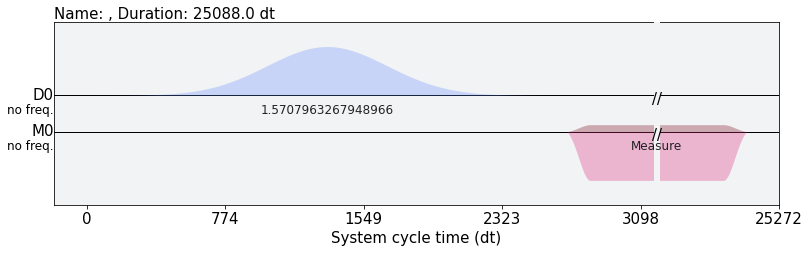

In [31]:
X_rotation_schedule.draw()

In [32]:
X_rotation_job = backend.run(X_rotation_schedule)


KeyboardInterrupt: 

In [36]:
X_rotation_data= get_job_data(X_rotation_job, average=False)

def IQ_X180_X180_plot(x_min, x_max, y_min, y_max, X_rotation_data):
    """Helper function for plotting IQ plane for |0>, |1>. Limits of plot given
    as arguments."""
    plt.scatter(np.real(X_rotation_data), np.imag(X_rotation_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')

    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

x_min = -15
x_max = 0
y_min = -30
y_max = 0
IQ_X180_X180_plot(x_min,x_max, y_min, y_max, X_rotation_data)

NameError: name 'X_rotation_job' is not defined

# Results from device

# X 180
$|1>$

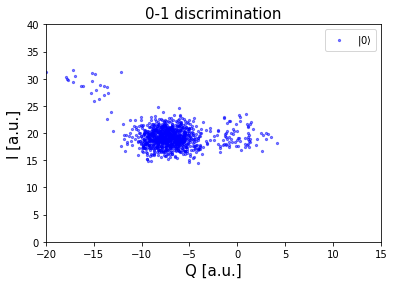

# X 90
$\frac{1}{\sqrt(2)}|0> + \frac{1}{\sqrt{2}}|1>$ X_180

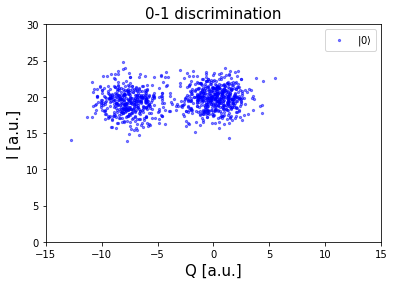